# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
#!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
#!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.
월급이 기이하게 분포 되어 있다.
표준 급여를 받는 사람이 많다. MSE 최소화에 불편한 분포가 오른쪽 측면에서 꼼꼼하게 나타납니다.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.
이를 해결하기위한 여러 가지 기술이 있습니다. 즉, 다른 손실 함수 사용, 원시 타겟 대신 로그 타겟을 예측하거나 트레이닝 세트의 모든 급여 중 목표를 백분위 수로 대체하는 것입니다. 우리는 대수(대신하는수)를 사용할 것입니다.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

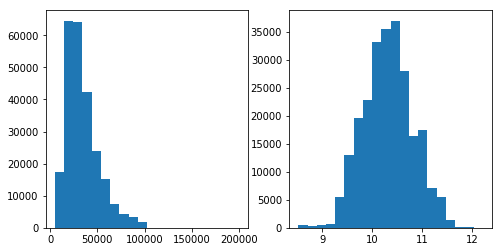

In [3]:
#data = data.head(3)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)

plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [4]:
data['Log1pSalary'].shape

(244768,)

In [5]:
np.amax(data["SalaryNormalized"])

200000

In [6]:
np.amin(data["SalaryNormalized"])

5000

In [7]:
np.amax(data["Log1pSalary"])

12.206078

In [8]:
np.amin(data["Log1pSalary"])

8.517393

Our task is to predict one number, __Log1pSalary__. (log(1 + 200000))

Log1pSalary 예측이 임무

Title : Job position  
FullDescription : 실제 할일  
LocationRaw : 위치 (Detail)  
LocationNormalized : 위치  
Contract Type : 계약 유형  
Contract Time : 계약 시간  
Company : 회사  
Category : 범주  
SalaryRaw : 급여 범위 및 추가 속성  
SalaryNormalized : 급여 평균  
SourceName : 출처  

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

dropna함수는 column내에 NaN값이 있으면 해당 내용은 필요없다 간주하고 삭제해버린다.  

fillna함수도 굉장히 유용한다 NaN을 특정 값으로 대체하는 기능을 한다.  




In [9]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
182771,71614858,Registered General Nurse (RGN) East London C...,Registered General Nurse/RN/RGNLocation: East ...,Chingford,Chingford,full_time,NaN,HC Recruitment Services,Healthcare & Nursing Jobs,13.00 - 13.15/Hour,25104,staffnurse.com,10.130822
44035,68506863,Buyer Menswear,Buyer Menswear : The Client This design led c...,North London London South East,North Lambeth,NaN,permanent,FASHION & RETAIL PERSONNEL LIMITED,Retail Jobs,40000 - 45000 per annum,42500,retailchoice.com,10.657283
101855,69547809,HGV 2 Moffett Driver,We have a breathtaking opportunity for a HGV C...,Southall,Southall,full_time,NaN,HR Go Recruitment,Logistics & Warehouse Jobs,8.50 - 12.75 per hour,20400,Jobcentre Plus,9.923339


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation(구두법), etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.


regexp를 사용하여 텍스트를 영문자 및 비영 문자의 순서로 토큰화    

\w+|[^\w\s]+.  

<p> from nltk.tokenize import WordPunctTokenizer  
<p> s = "Good muffins cost $3.88\nin New York.  Please buy me\ntwo of them.\n\nThanks." 

<p> WordPunctTokenizer().tokenize(s) 
<p> ['Good', 'muffins', 'cost', '$', '3', '.', '88', 'in', 'New', 'York', 
<p> '.', 'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']  



http://excelsior-cjh.tistory.com/63  

In [10]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()


index = 0
for item in data["FullDescription"]:
    data["FullDescription"][index] = tokenizer.tokenize(item)
    index = index + 1
    
index = 0
for item in data["Title"]:
    data["Title"][index] = tokenizer.tokenize(item)
    index = index + 1
# see task above
#<YOUR CODE HERE>

/Users/JunChangWook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Not all words are equally useful. Some of them are typos or rare words that are only present a few times.  
모든 단어가 똑같이 유용하지 않다. 몇몇 단어는 오타 또는 희귀 단어 이다.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.  
단어 카운트를 기반으로 유용한 단어 리스트를 만든다. (white lists)

In [ ]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
import collections

dictionary = []

for item in data["FullDescription"]:
    dictionary.extend(item)

for item in data["Title"]:
    dictionary.extend(item)

token_counts = collections.Counter(dictionary)
#token_counts = <YOUR CODE>

# hint: you may or may not want to use collections.Counter

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

#assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
#assert len(token_counts) in range(200000, 210000)
print('Correct!')

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10
temp_tokens = []

#for k,v in token_counts.items():
    #if v > min_count:
    #temp_tokens.append(k)

for k,v in token_counts.items():
    if v > min_count:
        temp_tokens.append(k)

tokens = temp_tokens
# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = <YOUR CODE HERE>

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
#token_to_id = <your code here>
token_to_id = {word: idx for idx, word in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.
행렬로 매핑하기  

>>> a = list(map(str, range(10)))  
>>> a  
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  


In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])
# 매트릭스 구조를 만들고 있다.
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    # object , classinfo 같으면 참 아니면 거짓
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    # 처음 한번은 양의 무한대와 비교하고 나머지는 시컨스 max_len와 비교 한다.    
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    # 전체를 패드로 만들고
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    # 사전에 있으면 그 인텍스를 아니면 UNK_IX를 넣어서 매트릭스를 구성하고 있다.
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
        print(matrix)
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

one-hot 인코딩을 사용   Advanced encoding : tf-idf  

>>> list(zip([1, 2, 3], [4, 5, 6]))  
[(1, 4), (2, 5), (3, 6)]  

set 순서가 없는 딕셔너리 만들기  
  


from sklearn.feature_extraction.text import CountVectorizer  
corpus = [  
    'This is the first document.',  
    'This is the second second document.',  
    'And the third one.',
    'Is this the first document?',  
    'The last document?',      
]
vect = CountVectorizer()  
vect.fit(corpus)  
vect.vocabulary_  
  

{'this': 9,  
 'is': 3,  
 'the': 7,  
 'first': 2,  
 'document': 1,  
 'second': 6,  
 'and': 0,  
 'third': 8,  
 'one': 5,  
 'last': 4}  
   
 
 vect.transform(['This is the second document.']).toarray()  
 
 array([[0, 1, 0, 1, 0, 0, 1, 1, 0, 1]])  
 
 vect.transform(['Something completely new.']).toarray()  
 
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  
 
 vect.transform(corpus).toarray()  
 
 array([[0, 1, 1, 1, 0, 0, 0, 1, 0, 1],  
       [0, 1, 0, 1, 0, 0, 2, 1, 0, 1],  
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0],  
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 1],  
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0]])  
       
     

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*collections.Counter(data['Company']).most_common(1000)) # 동일한 위치 묶어준다.
print(top_companies)
recognized_companies = set(top_companies)
print(recognized_companies)
# top 1000개 이상은 Company를 표현하고 아닌 모든 것들은 Other로 처리 한다. 여기에 pandas apply 함수를 통해 수행한다.
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
# dict를 y 축으로 묶는다. pandas apply 함수를 통해서 수행한다. 
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment. (토큰을 배웠고 이제 기계학습 실험)

As before, we won't focus too much on validation, opting for a simple train-test split. (학습 훈련 검증 셋 분할)

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

In [ ]:
# 배치 구성하는 함수
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data. (케라스 친화적으로 만든다)
    :param word_dropout: replaces token index with UNK_IX with this probability (word_dropout 확률로 UNK_IX로 대체)
    :returns: a dict with {'title' : int64[batch, title_max_len] (배치 사이즈, 타이틀 최대 크기) 매트릭스 구성
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    # target_column = "Log1pSalary"
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    # 변환 해준다. 모든 부분의 full_like 
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)]) # matrix를 replace_with로 변경한다.

In [ ]:
make_batch(data_train[:3], max_len=10)

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary. (급여 예측에 3개의 특성을 쓴다.)

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

https://keras.io/layers/merge/

In [ ]:
import keras
#from keras.models import Sequential
import keras.layers as L

In [ ]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    x1 = keras.layers.Dense(8, activation='relu')(l_title)
    x2 = keras.layers.Dense(8, activation='relu')(l_descr)
    x3 = keras.layers.Dense(8, activation='relu')(l_categ)
    added = keras.layers.add([x1, x2, x3])

    # <YOUR CODE>
    output_layer = keras.layers.Dense(1)(added)
    #output_layer = <...>
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [ ]:
model = build_model()
model.summary() # 모델 요약

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 
미니 배치 사용  

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

로그 공간에서 계산 된 손실 함수뿐만 아니라 달러로 측정 한 실제 오차를 모니터링하려고 합니다.  


In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function. (iterate_minibatches 함수는 무한 미니 버스 스트림 구성.)

In [ ]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()
#배치 별로 모델 트레이닝
model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

In [ ]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.
선형 모델은 비선형 모델 보다 쉽다고 이야기 하고 있음

There are, however, some ways to look inside the black box:
블랙 박스 들여다 보는 방법
* Seeing how model responds to input perturbations  
입력에 대해서 모델이 어떻게 응답하는지 본다.  
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)  
활성화된 뉴럴의 선택해 최대/최소 찾기
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)  
신경망에 대한 로컬 선형 근사법 작성  
Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)